In [1]:
import os
import copy
import numpy as np
import netCDF4 as nc
from scipy import stats
import xarray
import xesmf
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm, ListedColormap
import pyart
import cmocean

PC = ccrs.PlateCarree()

Could not save font_manager cache [Errno 28] No space left on device
/nbhome/role.medgrp/.conda/envs/medpy311/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Get a color map and normalization
# that are dividid into discrete colors.
# Set no_offset=False to match what xarray does
def get_map_norm(cmap, levels, no_offset=True):
    nlev = len(levels)
    #cmap = plt.cm.get_cmap(cmap, nlev)
    cmap = plt.cm.get_cmap(cmap, nlev-int(no_offset))
    colors = list(cmap(np.arange(nlev)))
    cmap = ListedColormap(colors, "")
    norm = BoundaryNorm(levels, ncolors=nlev, clip=False)
    return cmap, norm

In [3]:
def outline_nep_domain(ax,ncol,clon,clat):
    
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',facecolor='blanchedalmond')
    ax.add_feature(land_50m,zorder=50)
    ax.coastlines('50m',zorder=50)
    
    lin_col = 'dimgrey'
    #NEP DOMAIN OUTLINE
    ax.plot(clon[0,:],clat[0,:],linewidth=1.5,color=lin_col,transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,0],clat[:,0],linewidth=1.5,color=lin_col,transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[-1,:],clat[-1,:],linewidth=1.5,color=lin_col,transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,-1],clat[:,-1],linewidth=1.5,color=lin_col,transform=ccrs.PlateCarree(),zorder=42)
    
     # ADDING GRID LINES AND GRID LABELS
    gl = ax.gridlines(draw_labels=True)
    
    gl.xlocator = mticker.FixedLocator([180, -150, -120])
    gl.ylocator = mticker.FixedLocator([25, 55])
    
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    gl.bottom_labels = False
    gl.top_labels = False
    
    if ncol>0:
        gl.left_labels = False
        
    if ncol<2:
        gl.right_labels = False
    
    if nrow == 6:
        gl.bottom_labels = True
        
    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
    
    ax.set_extent([np.min(nep_clon),np.max(nep_clon),
                   np.min(nep_clat),70], crs=ccrs.PlateCarree()) 
    


In [4]:
def calc_stats_vals(NEP_val, comp_val):
    
    # Mean Bias
    mean_bias = np.nanmean(NEP_val-comp_val)
    
    if print_stats:
        print('MEAN BIAS:', mean_bias)

    
    nan_idx = ~np.isnan(NEP_val)*~np.isnan(comp_val)
    
    # Mean Bias Area Weighted
    amean_bias = np.nansum(((NEP_val*nep_area)[nan_idx]-(comp_val*nep_area)[nan_idx])/np.nansum(nep_area[nan_idx]))
    if print_stats:
        print('AREA-WEIGHTED MEAN BIAS:', amean_bias)

    # RMSE 
    rmse = np.sqrt(np.mean(((NEP_val-comp_val)**2)[nan_idx]))
    if print_stats:
        print('RMSE:', rmse)

    # RMSE Area weighted
    armse = np.sqrt(np.sum((((NEP_val-comp_val)**2)*nep_area)[nan_idx]/np.sum(nep_area[nan_idx])))
    if print_stats:
        print('AREA-WEIGHTED RMSE:', armse)

    # Median absolute error
    medae = np.nanmedian(np.abs(NEP_val-comp_val)[nan_idx])
    if print_stats:
        print('MEDIAN ABSOLUTE ERROR:', medae)

    # Correlation
    #nan_idx = ~np.isnan(slope_nep.ravel())*~np.isnan(slope_comp.ravel())
    corr = stats.pearsonr(NEP_val[nan_idx].ravel(), comp_val[nan_idx].ravel())
    if print_stats:
        print('CORRELATION:', corr)

    return mean_bias, amean_bias, rmse, armse, medae, corr

In [5]:
def plot_tides(constit, amp_levels, delta_levels,nlab):
    title_font_size=30
    ncol=0
    
    delta = model.A.sel(constit=constit) - tpxo_interp.sel(constit=constit)
    delta *= 100 # -> cm
    delta=delta.values
    delta[chuk_mask_nep]=np.nan
    
    if periods[constit] > 48:
        phase_levels = np.arange(0, periods[constit], 24) 
    else:
        phase_levels = np.arange(0, periods[constit], 1) 
        
    phase_colors = plt.get_cmap(phase_colormap)(np.linspace(0, 1, len(phase_levels)))
    #phase_colors = phase_colormap(np.linspace(0, 1, len(phase_levels)))
    
    cmap = 'magma'
    norm = BoundaryNorm(amp_levels, 256,extend='max')

    delta_cmap = cmocean.cm.balance
    delta_norm = BoundaryNorm(delta_levels, delta_cmap.N,extend='both')
    
    common = dict(cmap=cmap, norm=norm, transform=PC)

    #delta_cmap, delta_norm = get_map_norm(diff_colormap, levels=delta_levels)

    # NEP FIGURE
    nep_data = (model.A.sel(constit=constit)*100).values
    nep_data[chuk_mask_nep]=np.nan
    ax = fig.add_subplot(spec[nrow,ncol], projection=ccrs.PlateCarree(central_longitude=-100))
    p = ax.pcolormesh(model.geolon_c[::sub, ::sub], model.geolat_c[::sub, ::sub], nep_data, **common)
    
    nep_data = (model.g.sel(constit=constit)*periods[constit]/360).values
    nep_data[chuk_mask_nep]=np.nan
    ax.contour(model.geolon, model.geolat, nep_data, colors=phase_colors, levels=phase_levels, transform=PC)
    outline_nep_domain(ax,ncol,nep_clon,nep_clat)
    ax.set_title(f'{title} {constit}',fontsize=title_font_size)
    
    pos = ax.get_position()
    cax = fig.add_axes([pos.x0, pos.y0-.2*pos.height, 2*pos.width, .1*pos.height])
    cbar = plt.colorbar(p,cax=cax,orientation='horizontal',extend='max')
    cbar.ax.tick_params(labelsize=20)
    plt.setp(cbar.ax.spines.values(), linewidth=1,zorder=100)
    if nrow == 2: 
        cax.set_xlabel('Amplitude (cm)',fontsize=25)
    ax.text(160,65, plot_labels[nlab], fontsize=25, ha='center', va='center',
            transform=ccrs.PlateCarree(),zorder=55)
    
    ncol+=1
    nlab+=1

    # TPXO FIGURE
    tpxo_data=(tpxo_ha.sel(constit=constit)*100).values
    tpxo_data[chuck_mask_tpxo]=np.nan
    ax = fig.add_subplot(spec[nrow,ncol], projection=ccrs.PlateCarree(central_longitude=-100))
    p = ax.pcolormesh(tpxo.lon-360, tpxo.lat, tpxo_data, **common)
    
    tpxo_data=(tpxo_hp.sel(constit=constit)*periods[constit]/360).values
    tpxo_data[chuck_mask_tpxo]=np.nan
    ax.contour(tpxo.lon-360, tpxo.lat, tpxo_data, colors=phase_colors, levels=phase_levels, transform=PC)
    ax.set_title(f'TPXO9 {constit}',fontsize=title_font_size)
    outline_nep_domain(ax,ncol,nep_clon,nep_clat)
    ax.text(160,65, plot_labels[nlab], fontsize=25, ha='center', va='center',
            transform=ccrs.PlateCarree(),zorder=55)

    ncol+=2
    nlab+=1
    
    # Difference Figure
    mean_bias, amean_bias, rmse, armse, medae, corr = calc_stats_vals(100*model.A.sel(constit=constit).values, 
                                                                      100*tpxo_interp.sel(constit=constit).values)
    ax = fig.add_subplot(spec[nrow,ncol], projection=ccrs.PlateCarree(central_longitude=-100))
    p = ax.pcolormesh(model.geolon_c[::sub, ::sub], model.geolat_c[::sub, ::sub], delta, cmap=delta_cmap, norm=delta_norm, transform=PC)
    ax.set_title(f'{title} - TPXO9 {constit} Amplitude',fontsize=title_font_size)
    outline_nep_domain(ax,ncol,nep_clon,nep_clat)
    ax.text(160,65, plot_labels[nlab], fontsize=25, ha='center', va='center',
            transform=ccrs.PlateCarree(),zorder=55)
    print(np.nanmin(delta),np.nanmax(delta))
    pos = ax.get_position()
    cax = fig.add_axes([pos.x0, pos.y0-.2*pos.height, pos.width, .1*pos.height])
    cbar = plt.colorbar(p,cax=cax,orientation='horizontal',extend='both')
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.locator_params(nbins=5)
    plt.setp(cbar.ax.spines.values(), color='k',linewidth=1,zorder=100)
    stats_text = 'Bias: ' + f'{amean_bias:.2f}' + '\nRMSE: ' + f'{armse:.2f}' + '\nMedAE: ' + f'{medae:.2f}' + '\nR: ' + f'{corr[0]:.2f}' 
    #ax.text(233, 59, stats_text, 
    #            fontsize=16, ha='left', va='center',transform=ccrs.PlateCarree(), zorder=53)
    ax.text(.03, .05, stats_text, ha="left", va="bottom", size=26, bbox=stats_box_props,transform=ax.transAxes)
    if nrow == 2: 
        cax.set_xlabel('Difference (cm)',fontsize=25)
    


In [6]:
# NEP Grid
gridfil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'

grd_fid = nc.Dataset(gridfil)
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

nep_depth = grd_fid.variables['deptho'][:]
nep_area = grd_fid.variables['areacello'][:]
wet = grd_fid.variables['wet'][:]

nep_mask = copy.deepcopy(wet)
nep_mask[nep_mask>0]=1
nep_mask[nep_mask==0]=99999

chuk_mask_nep = nep_lat>66

plot_labels = ['a','b','c','d','e','f']

In [7]:
# File containing tides computed by compute_tides.py
model = xarray.open_dataset('/work/role.medgrp/NEP/plotting/Figure_6/NEP_tides.nc')
# Subsampling that was used when running compute_tides.py to save time
sub = 1
# Title of the model run to use in the plots
title = 'NEP10k'
# Title of the model run to use in the figure file names
filetitle = 'NEP10k'

In [8]:
# Periods of each harmonic constituent in hours.
# (for converting phase from degrees to hours)
periods = {
    'M2': 12.42, 
    'S2': 12, 
    'N2': 12.66,
    'K2': 11.97,
    'K1': 23.93, 
    'O1': 25.82,
    'P1': 24.07,
    'Q1': 26.87,
    'MF': 327.9,
    'MM': 661.3
}

tpxo = (
    xarray
    .open_dataset('/work/role.medgrp/NEP/plotting/Figure_6/h_tpxo9.v1.nc')
    .isel(ny=slice(500, 1200), nx=slice(800, 1700)) # approx NEP region subset
    .rename({'lon_z': 'lon', 'lat_z': 'lat'})
)

tpxo['constit'] = (('nc', ), ['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1', 'MM', 'MF', 'M4', 'MN4', 'MS4', '2N2', 'S1'])
tpxo = tpxo.swap_dims({'nc': 'constit'})

# Mask 0s over land
tpxo_ha = tpxo.ha.where(tpxo.ha > 0)
tpxo_hp = tpxo.hp.where(tpxo.hp > 0)

# Interpolate TPXO to MOM6 domain for computing difference of amplitude
tpxo_to_model = xesmf.Regridder(
    tpxo[['lon', 'lat']],
    model[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}),
    method='bilinear'
)

tpxo_interp = tpxo_to_model(tpxo['ha'])

#chukchi sea mask
chuck_mask_tpxo = tpxo.lat>66

In [9]:
# Projection and lat/lon limits for plotting the NEP grid
nep_proj = ccrs.LambertConformal(central_longitude=-120, central_latitude=45)
nep_extent = [-165, -105, 9, 84.4]

# Color map to use for amplitude shading
amp_colormap = 'magma'

# Color map to use for phase contour lines
phase_colormap = 'hsv'
#phase_colormap = cmocean.cm.phase

# Color map to use for the shading in the amplitude difference plot
diff_colormap = 'coolwarm'
#diff_colormap = cmocean.cm.balance


-221.57393370628412 255.00916772234933
-91.07900923402411 68.88435485099542


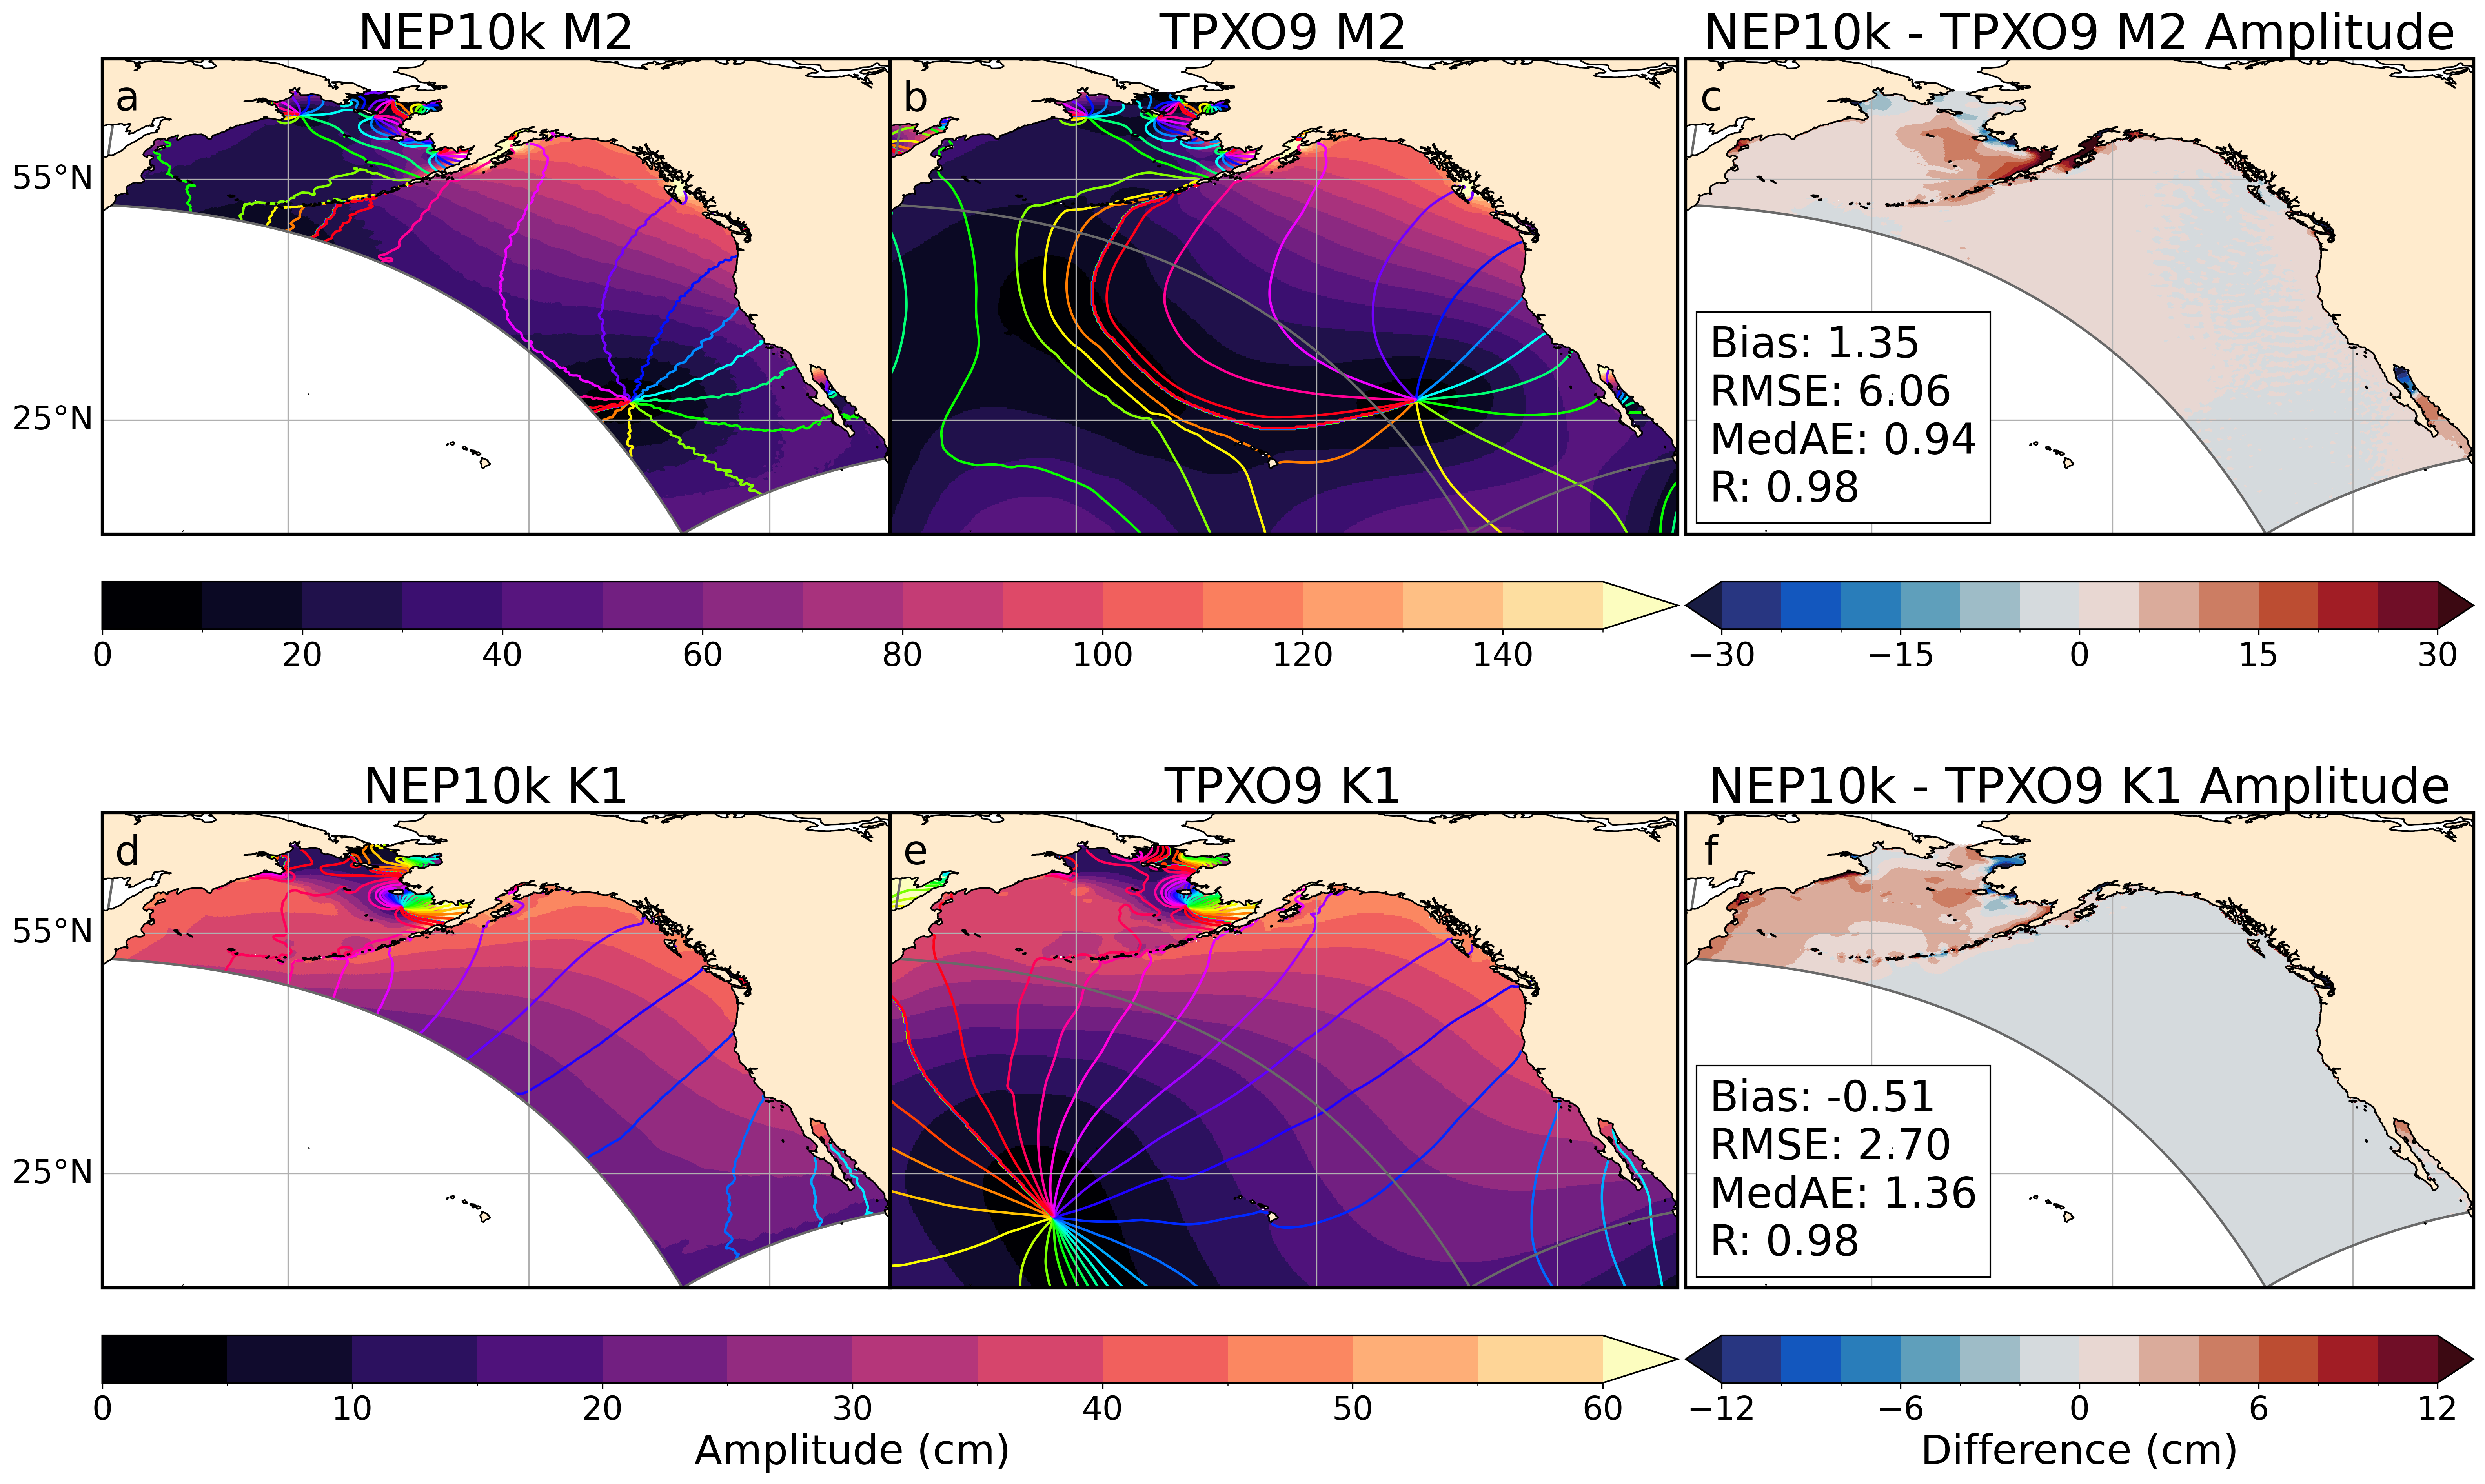

In [10]:
# Create Figure Object    
print_stats = False
stats_box_props = dict(boxstyle="square", fc="w", ec="0.0", alpha=1)
fig = plt.figure(figsize=(26,16),dpi=300)

heights = [10,3,10,2]
widths = [10,10,.1,10]
spec = fig.add_gridspec(ncols=4, nrows=4,wspace=0,hspace=0.,height_ratios=heights, width_ratios=widths)  

nrow=0
plot_tides('M2', np.arange(0, 150+1, 10), np.arange(-30, 31, 5), 0)

nrow+=2
plot_tides('K1', np.arange(0, 60+1, 5),   np.arange(-12, 13, 2), 3)

plt.savefig('Figure6_TPXO9_tide_comparison')